# Arrhythmic Heartbeat Classification Model
## ECE 284 Project - Spring 2025
## Stephen Wilcox

In [ ]:
%pip install --user wfdb numpy scipy matplotlib scikit-learn torch torchvision torchaudio biosppy peakutils

In [1]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from biosppy.signals import ecg
from collections import Counter
import time

In [2]:
BEAT_DURATION = 1.0  #seconds
DATA_DIR = '../data'
MITDB_PATH = os.path.join(DATA_DIR, 'mitdb')
NSRDB_PATH = os.path.join(DATA_DIR, 'nsrdb')


def extract_beat(signal, r_loc, beat_len):
    half_len = beat_len // 2
    if r_loc - half_len < 0 or r_loc + half_len > len(signal):
        return None
    return signal[r_loc - half_len: r_loc + half_len]

def process_mitdb_record(record_name):
    record_path = os.path.join(MITDB_PATH, record_name)
    record = wfdb.rdrecord(record_path)
    ann = wfdb.rdann(record_path, 'atr')
    signal = record.p_signal[:, 0]
    fs = record.fs
    beat_len = int(BEAT_DURATION * fs)

    beats = []
    labels = []
    for i, r_loc in enumerate(ann.sample):
        beat = extract_beat(signal, r_loc, beat_len)
        if beat is not None:
            beats.append(beat)
            labels.append(ann.symbol[i])
    return beats, labels

def process_nsrdb_record(record_name, segment_duration=3600):
    record_path = os.path.join(NSRDB_PATH, record_name)
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]
    fs = record.fs

    segment_samples = int(segment_duration * fs)
    if segment_samples > len(signal):
        segment_samples = len(signal)

    segment_signal = signal[:segment_samples]

    # Run ECG peak detection on the 1-hour segment only
    ts, filtered, rpeaks, *_ = ecg.ecg(signal=segment_signal, sampling_rate=fs, show=False)

    beats = []
    labels = []

    for r in rpeaks:
        beat = extract_beat(filtered, r, beat_len=128)
        if beat is not None:
            beats.append(beat)
            labels.append('N')  # assume normal for NSRDB
    print(f"Processed NSRDB record {record_name}, beats found: {len(beats)}")
    return beats, labels



In [3]:
PROCESSED_DATA_PATH = os.path.join(DATA_DIR, 'processed_beats_f.npz')

def upsample_list(data, target_len):
    original_indices = np.linspace(0, 1, num=len(data))
    target_indices = np.linspace(0, 1, num=target_len)
    return np.interp(target_indices, original_indices, data)


def load_data():
    if os.path.exists(PROCESSED_DATA_PATH):
        print("Loading preprocessed data...")
        data = np.load(PROCESSED_DATA_PATH, allow_pickle=True)
        return data['X_scaled'], data['y'], data['label_map'].item()
    
    X = []
    y = []

    print("Processing MIT-BIH...")
    mit_records = [f[:-4] for f in os.listdir(MITDB_PATH) if f.endswith('.dat')]
    for rec in mit_records:
        beats, labels = process_mitdb_record(rec)
        X.extend(beats)
        y.extend(labels)

    print("Total beats extracted:", len(X))

    print("Processing NSRDB...")
    nsr_records = [f[:-4] for f in os.listdir(NSRDB_PATH) if f.endswith('.dat')]
    for rec in nsr_records:
        beats, labels = process_nsrdb_record(rec, segment_duration=3600)
        for ind in range(len(beats)):
            beats[ind] = upsample_list(beats[ind], 360)
        X.extend(beats)
        y.extend(labels)

    print("Total beats extracted:", len(X))

    # Only keep labels that are in the AAMI beat mapping
    #https://pmc.ncbi.nlm.nih.gov/articles/PMC4897569/#:~:text=The%20AAMI%20convention%20is%20used,ventricular%20contraction%20(PVC)%20and%20ventricular
    aami_mapping = {
        'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
        'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
        'V': 'V', 'E': 'V',
        'F': 'F',
        '/': 'Q', 'f': 'Q', 'Q': 'Q', '|': 'Q'
    }

    # Filter and map labels during loading
    X_filtered = []
    y_filtered = []

    for xi, yi in zip(X, y):
        if yi in aami_mapping:
            X_filtered.append(xi)
            y_filtered.append(aami_mapping[yi])

    X = X_filtered
    y = y_filtered

    X_scaled = X

    # Map labels to integers
    label_set = sorted(set(y))
    label_map = {lbl: i for i, lbl in enumerate(label_set)}
    y_int = np.array([label_map[lbl] for lbl in y])

    # Save processed data
    np.savez_compressed(PROCESSED_DATA_PATH, X_scaled=X_scaled, y=y_int, label_map=label_map)
    print(f"Saved preprocessed data to {PROCESSED_DATA_PATH}")
    
    return X_scaled, y_int, label_map

In [4]:
# Load or process data
X_scaled, y, label_map = load_data()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=69
)

print("Class distribution:", Counter(y))
print(label_map)

class ECGDataset(Dataset):
    def __init__(self, X, y):
        #self.X = torch.tensor(X, dtype=torch.float32)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and loaders
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Loading preprocessed data...
Class distribution: Counter({1: 179111, 2: 8170, 4: 7235, 3: 2781, 0: 802})
{'F': 0, 'N': 1, 'Q': 2, 'S': 3, 'V': 4}


In [5]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class ECGClassifier(nn.Module):
    def __init__(self, input_length, num_classes):
        super(ECGClassifier, self).__init__()

        def conv_se_block(in_channels, out_channels, kernel_size, padding, pool=True):
            layers = [
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                SEBlock(out_channels)
            ]
            if pool:
                layers.append(nn.MaxPool1d(kernel_size=2))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            conv_se_block(1, 16, kernel_size=7, padding=3),
            conv_se_block(16, 32, kernel_size=7, padding=3),
            conv_se_block(32, 64, kernel_size=5, padding=2),
            conv_se_block(64, 128, kernel_size=5, padding=2),
            conv_se_block(128, 256, kernel_size=3, padding=1),
            conv_se_block(256, 512, kernel_size=3, padding=1),
            conv_se_block(512, 1024, kernel_size=3, padding=1),
        )

        final_length = input_length // 128
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * final_length, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        x = self.classifier(x)
        return x

In [6]:
input_length = X_scaled.shape[1]
num_classes = len(label_map)
# print(label_map)
print(input_length)

model = ECGClassifier(input_length=input_length, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

360


ECGClassifier(
  (features): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SEBlock(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SEBlock(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=3

In [7]:
checkpoint_path = os.path.join(DATA_DIR, 'ecg_checkpoint_fupgcnn2_2.pth')
start_epoch = 0
num_epochs = 80
best_loss = float('inf')
learning_rate = 5e-3
weight_dec = 1e-5
step_size = 20
gamma = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_dec)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    print(f"Loaded checkpoint, loss: {best_loss:.4f}")


# Training loop
for epoch in range(0, num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, best loss: {best_loss:.4f}, time: {(time.time()-start_time):.3f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print("Checkpoint saved.")

    scheduler.step()

Epoch 1/80, Loss: 0.0885, best loss: inf, time: 38.443
Checkpoint saved.
Epoch 2/80, Loss: 0.0444, best loss: 0.0885, time: 36.963
Checkpoint saved.
Epoch 3/80, Loss: 0.0378, best loss: 0.0444, time: 36.917
Checkpoint saved.
Epoch 4/80, Loss: 0.0341, best loss: 0.0378, time: 37.922
Checkpoint saved.
Epoch 5/80, Loss: 0.0319, best loss: 0.0341, time: 37.721
Checkpoint saved.
Epoch 6/80, Loss: 0.0303, best loss: 0.0319, time: 37.595
Checkpoint saved.
Epoch 7/80, Loss: 0.0261, best loss: 0.0303, time: 37.672
Checkpoint saved.
Epoch 8/80, Loss: 0.0259, best loss: 0.0261, time: 37.030
Checkpoint saved.
Epoch 9/80, Loss: 0.0247, best loss: 0.0259, time: 37.452
Checkpoint saved.
Epoch 10/80, Loss: 0.0238, best loss: 0.0247, time: 36.333
Checkpoint saved.
Epoch 11/80, Loss: 0.0241, best loss: 0.0238, time: 36.429
Epoch 12/80, Loss: 0.0234, best loss: 0.0238, time: 36.698
Checkpoint saved.
Epoch 13/80, Loss: 0.0231, best loss: 0.0234, time: 36.818
Checkpoint saved.
Epoch 14/80, Loss: 0.0226, be


Overall Test Accuracy: 99.60%

Per-Class Accuracy:
F, Fusion beat: 83.230%
N, Normal beat: 99.855%
Q, Unknown beat: 99.388%
S, Supraventricular ectopic beat: 92.986%
V, Ventricular ectopic beat: 97.789%


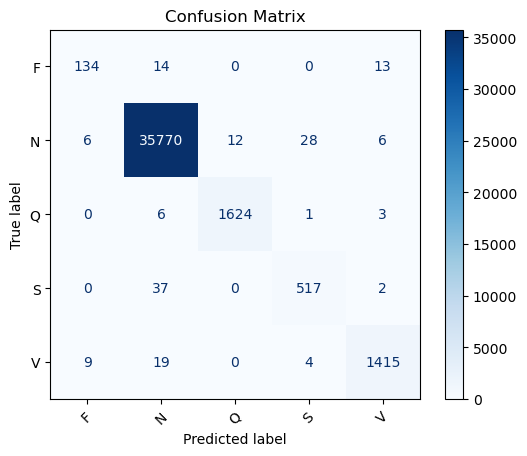

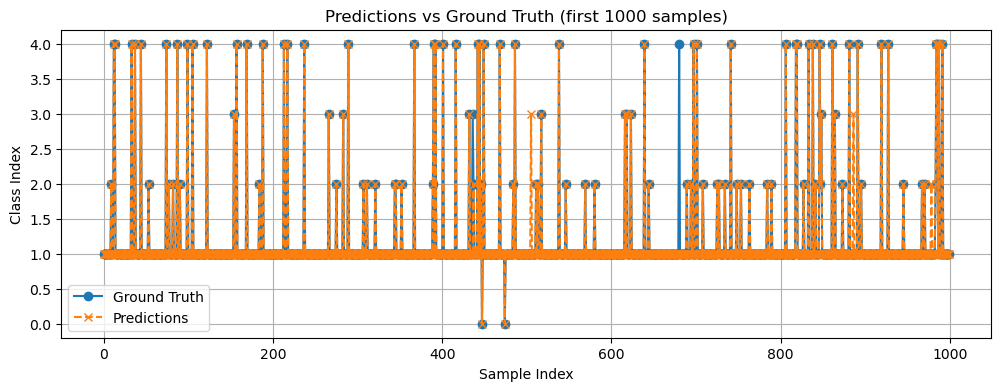

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# print("Class distribution:", Counter(y))
# class_totals = Counter(y)
# print(label_map)

#https://pmc.ncbi.nlm.nih.gov/articles/PMC4897569/#:~:text=The%20AAMI%20convention%20is%20used,ventricular%20contraction%20(PVC)%20and%20ventricular
def label_to_name(label):
    if label == 'N':
        return 'Normal beat'
    elif label == 'S':
        return 'Supraventricular ectopic beat'
    elif label == 'V':
        return 'Ventricular ectopic beat'
    elif label == 'F':
        return 'Fusion beat'
    elif label == 'Q':
        return 'Unknown beat'

def evaluate_model(model, test_loader, label_map, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Overall accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Test Accuracy: {acc * 100:.2f}%")

    # Per-class accuracy
    cm = confusion_matrix(all_labels, all_preds)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\nPer-Class Accuracy:")
    index_to_label = {v: k for k, v in label_map.items()}
    for i, acc in enumerate(per_class_acc):
        label_name = index_to_label.get(i, str(i))
        print(f"{label_name}, {label_to_name(label_name)}: {acc * 100:.3f}%")

    # Confusion Matrix Plot
    display_labels = [index_to_label.get(i, str(i)) for i in range(cm.shape[0])]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Predictions vs. Ground Truth Plot
    plt.figure(figsize=(12, 4))
    plt.plot(all_labels[:1000], label='Ground Truth', marker='o', linestyle='-')
    plt.plot(all_preds[:1000], label='Predictions', marker='x', linestyle='--')
    plt.legend()
    plt.title("Predictions vs Ground Truth (first 1000 samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Class Index")
    plt.grid(True)
    plt.show()

    return acc, all_preds, all_labels


acc, preds, labels = evaluate_model(model, test_loader, label_map, device)